In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slopes_r_p_onlysub, slopes_r_p_mix, slope_time, slope_maps
import regression
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')

In [5]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)


perc_step = 5
nbins = int(100/perc_step) # Number of bins.
popmean = 0

In [6]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

In [7]:
# lat and lon
lon_M = ds_hourly['nav_lon'].values
lat_M = ds_hourly['nav_lat'].values

In [8]:
sst = ds_hourly['SST'] #.groupby('time_counter.day').mean()            
sst = sst[::3]
# sst = sst.where(sea_mask_modified, drop=False).values; 

q2 = ds_hourly['Q2'] #.groupby('time_counter.day').mean()  
q2 = q2[::3]
# q2 = q2.where(sea_mask_modified, drop=False).values; 

In [9]:
U, V = xr.open_dataset(wrf_files[files_ls.index('U.nc')]), xr.open_dataset(wrf_files[files_ls.index('V.nc')])
U = U['U'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
V = V['V'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

U10, V10 = U[:,0,:,:], V[:,0,:,:]
U10, V10 = 0.5*(U10[:,:,0:-1]+U10[:,:,1:]) , 0.5*(V10[:,0:-1,:]+V10[:,1:,:])

U10, V10 = U10.where(sea_mask_modified, drop=False).values, V10.where(sea_mask_modified, drop=False).values
# ws_10 = (U10**2+V10**2)**0.5

In [10]:
LH = ds_hourly['LH']   #.groupby('time_counter.day').mean()            
LH = LH.where(sea_mask_modified, drop=False).values; 
LH = LH[::3]

In [11]:
s = 75

dLH = np.zeros(LH.shape)

for t in range(0,LH.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    LH_ave = gm.nan_gaussian_filter(LH[t],s)                             
    dLH[t] = LH[t] - LH_ave

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230


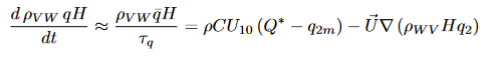

### compute spatial gradient of Q2

In [21]:
grad_q2 = mpcalc.gradient(q2*1000, axes=(1,2), deltas=[2,2])

In [25]:
dq_dy, dq_dx = grad_q2[0], grad_q2[1]

In [26]:
grad_abs = np.sqrt(dq_dy**2+dq_dx**2)

In [30]:
grad_abs.shape

(232, 546, 573)

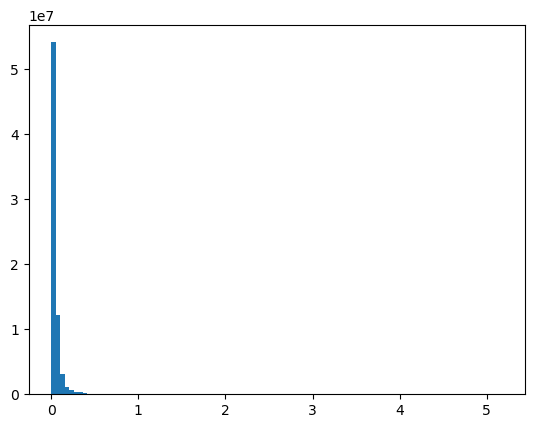

In [33]:
plt.hist(grad_abs.magnitude.flatten(), bins=100)
plt.show()

In [34]:
from scipy import stats

stats.mode(grad_abs.magnitude.flatten())

ModeResult(mode=array([0.00290022]), count=array([8]))

In [18]:
# np.nanpercentile(grad_q2, 80)

plt.hist(grad_q2.values.flatten(), density=True)
plt.show()

AttributeError: 'tuple' object has no attribute 'values'

In [20]:
[len(a) for a in grad_q2]

[232, 232]

In [21]:
dq_dx, dq_dy = grad_q2[1], grad_q2[0]
dq_dx.shape

(232, 546, 573)

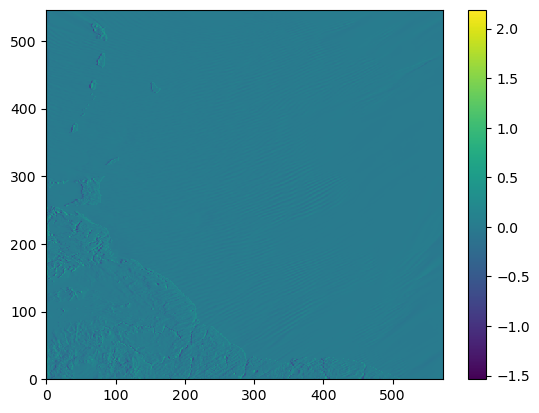

In [22]:
plt.pcolormesh(dq_dx[10])
plt.colorbar()

In [ ]:
COMPUTE ADVECTION

In [23]:
advection = -U10*dq_dx - V10*dq_dy

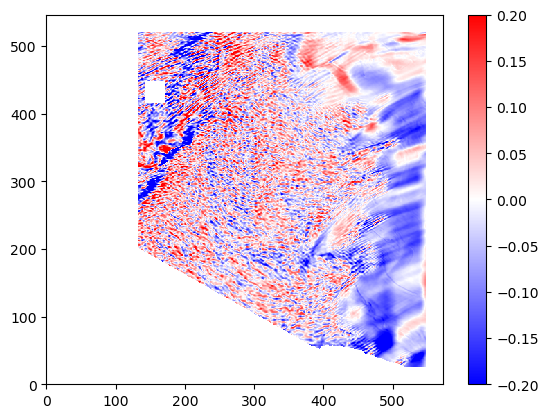

In [30]:
plt.pcolormesh(advection[30], cmap='bwr', vmin=-0.2, vmax=0.2)
plt.colorbar()

KeyboardInterrupt: 

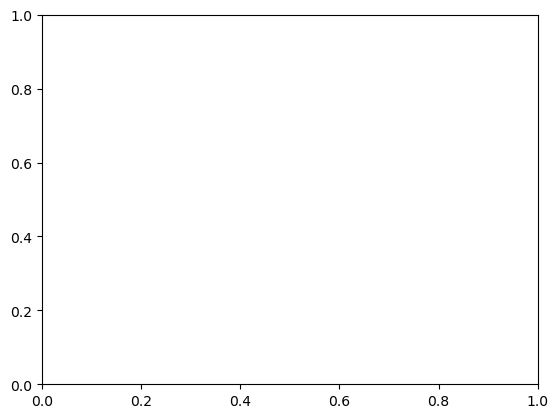

In [31]:
plt.hist(advection[~np.isnan(advection)].flatten())
plt.show()

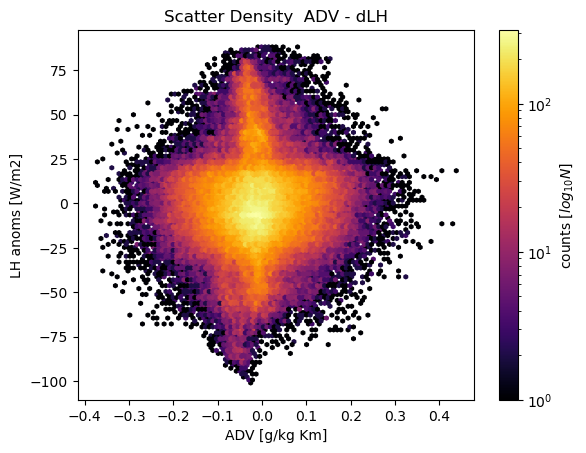

In [43]:
lh_anoms = True
if not lh_anoms:
    x = advection[0]
    y = LH[12]  
#     fit, corcoe, p_value, t_value_cannelli, p_value_cannelli = slopes_r_p_mix(x, y, nt, nskip)
    title=' Scatter Density ADV - LH'
    xlabel='ADV [g/kg Km]'
    ylabel='LH [W/m2]'
    
else:
    x = advection[0]
    y = dLH[12]     
#     fit, corcoe, p_value, t_value_cannelli, p_value_cannelli = slopes_r_p_mix(x, y, nt, nskip)
    title='Scatter Density  ADV - dLH'
    xlabel='ADV [g/kg Km]'
    ylabel='LH anoms [W/m2]'
    

fig = density_hexbin(x,y,fit=None,corcoe=None,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=[0.1,0.9])

## TODO apply Reynold's decomp to advection and do the same plot

In [12]:
qa_bar = np.zeros(q2.shape); U_bar = np.zeros(U10.shape); V_bar = np.zeros(V10.shape)
qa_prime = np.zeros(q2.shape); U_prime = np.zeros(U10.shape); V_prime = np.zeros(V10.shape)

sigma, sigma_sub = 75, 0

for t in range(0,sst.shape[0]):
    qa_bar[t] = gm.nan_gaussian_filter(q2[t],sigma)
    X_prime = q2[t] - qa_bar[t]
    qa_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)
    
    U_bar[t] = gm.nan_gaussian_filter(q2[t],sigma)
    X_prime = U10[t] - U_bar[t]
    U_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)
    
    V_bar[t] = gm.nan_gaussian_filter(V10[t],sigma)
    X_prime = V10[t] - V_bar[t]
    V_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)
    

In [13]:
grad_bar = mpcalc.gradient(qa_bar*1000*units('g/kg'), axes=(1,2), deltas=[2,2])
advection_bar = -U_bar*grad_bar[1]-V_bar*grad_bar[0]

grad_prime = mpcalc.gradient(qa_prime*1000*units('g/kg'), axes=(1,2), deltas=[2,2])
advection_prime = -U_prime*grad_prime[1]-V_prime*grad_prime[0]
advection_prime_mean = gm.nan_gaussian_filter(advection_prime, sigma)

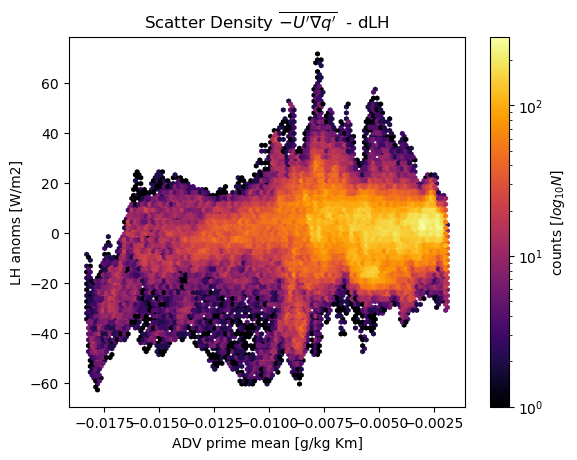

In [26]:
lh_anoms = True
if not lh_anoms:
    x = advection_bar
    y = LH
#     fit, corcoe, p_value, t_value_cannelli, p_value_cannelli = slopes_r_p_mix(x, y, nt, nskip)
    title=' Scatter Density ADV - LH'
    xlabel='ADV bar [g/kg Km]'
    ylabel='LH [W/m2]'
    
else:
    x = advection_prime_mean[0]
    y = dLH[1]
#     fit, corcoe, p_value, t_value_cannelli, p_value_cannelli = slopes_r_p_mix(x, y, nt, nskip)
    title=r"Scatter Density $\overline{-U'\cdot\nabla q'}$  - LH'"
    xlabel='ADV prime mean [g/kg Km]'
    ylabel='LH anoms [W/m2]'
    

fig = density_hexbin(x,y,fit=None,corcoe=None,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=[0.1,0.9])

### TODO compute spatial grad also of Q10